The programm uses a competitive hopfield neural network to segment the image shown in the provided papers [(1)](https://www.researchgate.net/publication/262363260_Segmentation_of_industrial_X-ray_images) [(2)](https://www.researchgate.net/publication/3220680_Application_of_competitive_Hopfield_neural_network_to_medical_image_segmentation)

A hopfield neural network minimizes it's energy function $E=-\sum_{i=1}^N\sum_{j=1}^N w_{ij} v_i v_j - \sum_{i=1}^n I_i v_i$

Gray levels in the same segment have to be similar in relative frequency in the image and color. Adjacent segments should have significant differences in frequency. By minimizing these distances within segments we get to a solution for the segmentation.

Relative frequency is measured with the histogram H and color similarity with euclidian distance $DIS_{x,y} = (G_x-G_y)^2$

If the weights are represented as:
$w_{x,i;y,i}=-\frac{H_y V_{y,i}}{\sum_{y=1}^n H_y * V_{y,i}}V_{x,i} DIS_{x,y}$

The energy function can be then calculated as:
$E=\sum_{x=1}^n\sum_{y=1}^n\sum_{i=1}^c\frac{H_y * V_{y,i}}{\sum_{y=1}^n H_y * V_{y,i}} DIS_{x,y}$

Neurons that have similar gray-levels and frequencies are more likley to be grouped together

To ensure that each gray level belongs to only 1 class a "Winner take all" strategy is implemented. The maximum neuron in
a row the wins and is assigned 1 and all others are assigned 0. And there is no bias so $I_{x}=0$ always holds

The matrix V contains c classes each with n neurons
$$
\begin{matrix}
Class\ 1 & Class\ 2 & \dots & Class\ c & \\
Net_{1,1} & Net_{1,2} & \dots & Net_{1,c} & \text{gray-level 1}\\
Net_{2,1} & Net_{2,2} & \dots  & Net_{2,c} & \text{gray-level 2}\\
\dots & \dots & \dots  & \dots\\
Net_{n,1} & Net_{n,2} & \dots  & Net_{n,c} & \text{gray-level n}
\end{matrix}
$$

1. Input the gray levels of n (colors of the image, n = 256 for 8bit images), $G = \set{g_1, g_2, \dots, g_n}$ and the number of classes in the image c
2. Compute the DIS matrix and histogram H

    The distance matrix is calculated as the euclidian distance between gray-levels $DIS_{x,y} = (g_x - g_y)^2$
3. Calculate the total input of each neuron in a row x
$$
Net_{x,i}=-\frac{1}{\sum_{y=1}^n H_y * V_{y,i}} \sum_{y=1}^n DIS_{x,y} * H_y * V_{y,i}
$$
4. Apply the winner takes all learning scheme on the row x
5. Repeat 3. and 4. for all rows. If there are no changed neurons, the final state of the neurons indicates the gray levels being assigned to classes. Otherwise return to step 3

In [1]:
# imports
import numpy as np
from PIL import Image # For showing images in the notebook
import cv2 # read/write images, treshold, highlight
from tqdm.notebook import tqdm # Progress bar

In [2]:
# Classes (splits image into c colors)
c = 4
# Grey-levels (number of colors to be segmented, that get turned into neurons)
n = 256

In [3]:
# Loading images

# From .tiff
le = cv2.imread('LE.tif', cv2.IMREAD_ANYDEPTH)
he = cv2.imread('HE.tif', cv2.IMREAD_ANYDEPTH)

# le = cv2.imread('LE_clear_test.tif', 0)
# he = cv2.imread('LE_clear_test.tif', 0)

# From .csv
# le = np.genfromtxt('LE.csv', delimiter=',', skip_header=True)
# he = np.genfromtxt('HE.csv', delimiter=',', skip_header=True)

n = min(n, le.max()+1) # no need to use n bigger than the highest grey-value. Grey values can only be integers

le = cv2.normalize(le, None, 0, n-1, cv2.NORM_MINMAX).astype(np.uint) # some tiff files must be normalized (csv file values are [0-922.09])
he = cv2.normalize(he, None, 0, n-1, cv2.NORM_MINMAX).astype(np.uint)

In [4]:
# Crop
# Best results with 13 classes when cropped

######### 1 ################
# le = le[:,150:900]
# he = he[:,150:900]
# c = 11
######### 1 ################


######### 2 ################
# def crop(imgArr):
#     "Crop black space on the left and right side of the image"
#     i=0
#     while imgArr[0][i] == 0:
#         i+=1
#     imgArr = imgArr[:,i:]
#     i = imgArr.shape[1]-1
#     while imgArr[0][i] == 0:
#         i-=1
#     return imgArr[:,:i]

# le = crop(le)
# he = crop(he)
# c = 11
######### 2 ################

In [5]:
# Initialise gray levels [0,n-1]
G = np.arange(n)
# Preprocess euclidian distances between each gray-level
DIS = (np.tile(G, (n, 1)).transpose() - G)**2 # same as dis(x,y) := (G[x] - G[y])^2

In [6]:
# Calc histogram of he and le gray levels
H = np.histogram(le.flatten(), n)[0] + np.histogram(he.flatten(), n)[0]

In [7]:
# Initializing the neural network

V = np.zeros((G.size,c))
V[:,c-1] = 1

# Random network start only shuffles the final gray-level values
# V[:,0] = 1
# for row in V:
#     np.random.shuffle(row)

In [8]:
# Network functions

def net(x, i):
    """
    Net input to the (x,i)th neuron
    
    for y in range(n):
    
        nu += d(x,y)*H[y]*V[y][i]

        de += H[y]*V[y][i]

    return -nu.sum()/de.sum()
    """
    nu = H*V[:,i] # numerator
    de = nu.sum() # denominator
    nu *= DIS[x,:]
    # nu *= (G[x]-G[:])**2 # if DIS would be too big to fit into memory
    return -nu.sum()/de

def wta(x, active):
    """
    'Winner take all'. Biggest value in row x is set to 1, all other 0
    
    Returns True if the active neuron changed
    """

    m = V[x].argmax()

    V[x][:] = 0
    V[x][m] = 1

    if(active != m):
        return True
    return False

In [9]:
# Running the network

def run_once(bar):
    "Update all neurons row by row. Returns True if any rows changed"
    changed = False
    bar.reset()
    for x in range(n):
        active = V[x].argmax()
        for i in range(c):
            V[x][i] = net(x, i)
        changed |= wta(x, active)
        
        bar.update(1)
    
    return changed
def run():
    "Run till limit or until there are no changing neurons"
    # Show progress bar with tqdm
    limit = 150
    i = 0
    changed = True
    with tqdm(desc="Rows updated", total=n, leave=False) as bar:
        with tqdm(desc="Iterations done", total=limit, leave=False) as pbar:
            while changed and i<limit:
                changed = run_once(bar) # stop early if there are no changes in network
                # run_once(bar) # ignore early stop
                pbar.update(1)
                i+=1
            # pbar.set_description("Processing finished")
            bar.update(n-bar.n)
            pbar.update(limit-pbar.n)
    print("Iterations done:", i)

In [10]:
run()

Rows updated:   0%|          | 0/256 [00:00<?, ?it/s]

Iterations done:   0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\Luka\AppData\Local\Temp\ipykernel_3192\4211373253.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return -nu.sum()/de


Iterations done: 6


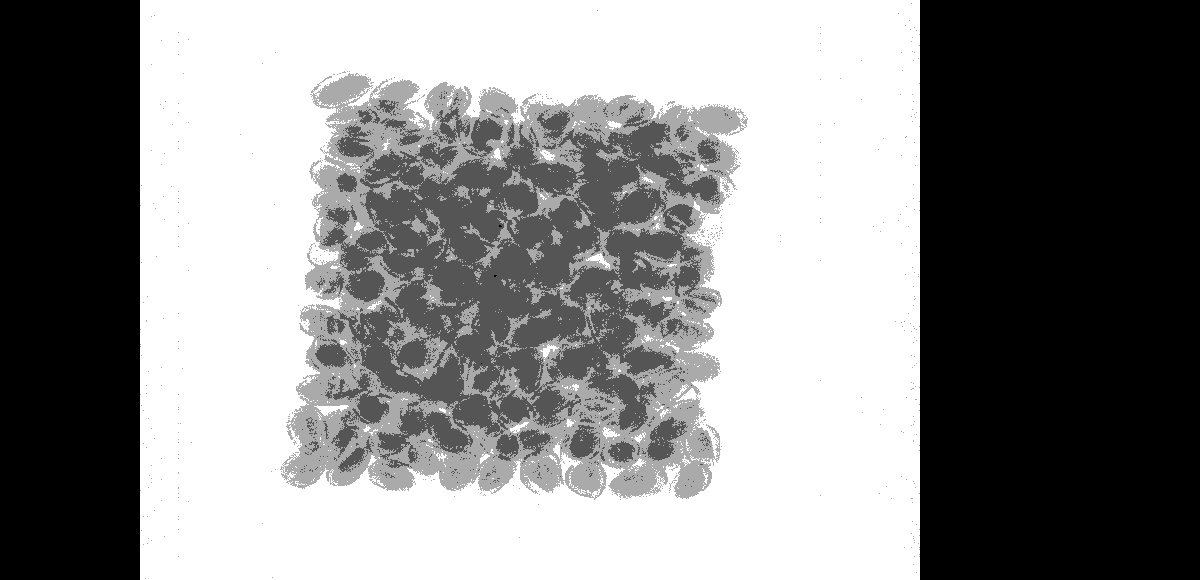

In [11]:
# Show segmented image

def smallestFormat(c):
    "Get smallest grayscale image resolution format"
    if c <= 2**8:
        return (2**8, np.uint8)
    else:
        if(c > 2**64):
            raise Exception("Too many classes to show as an image")
        if(c < 2**16):
            return (2**16, np.uint16)
        if(c < 2**32):
            return (2**32, np.uint32)
        return (2**64, np.uint64)

outpFormatInt, outpFormatNp = smallestFormat(c)

# array of c equidistant ints [0, image_resolution]
classValue = np.arange(0,outpFormatInt-1+(outpFormatInt-1)/(c-1),(outpFormatInt-1)/(c-1)).astype(np.uint)

# A map/dictionary of gray level values to the representative class color
classified = (V*classValue).max(axis=1)

# Use the map to show a segmented image
# for each x in img returns classified[x]
imgArr = np.take(classified, le.flatten()).reshape(le.shape)

# Show image with only c colors/graylevels
Image.fromarray(imgArr.astype(outpFormatNp))

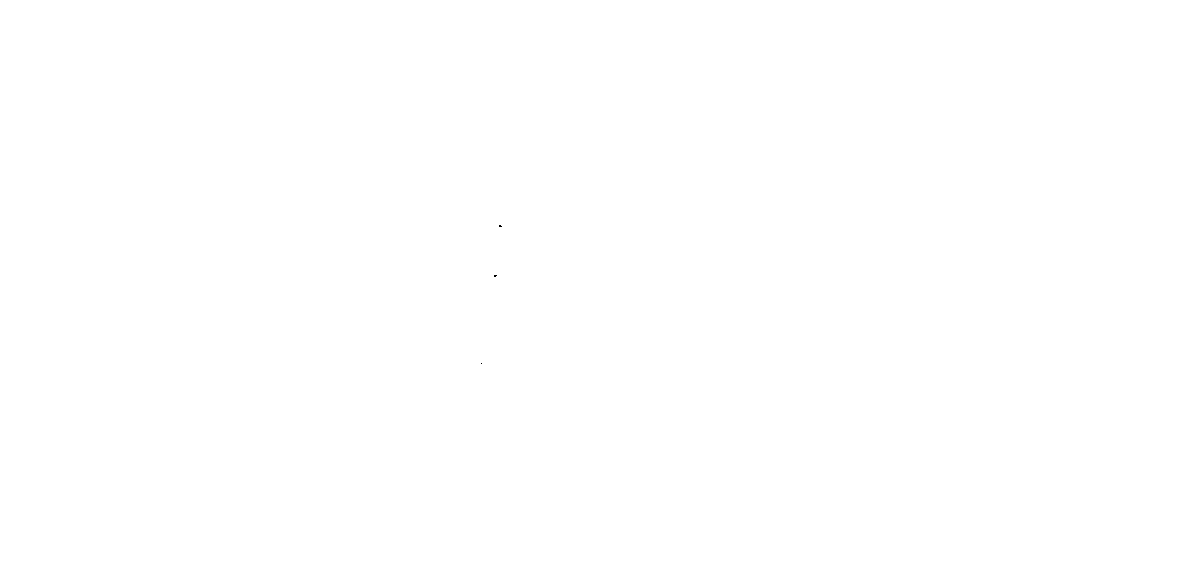

In [12]:
# Threshold

method = cv2.THRESH_BINARY # Output white background, black segments
# method = cv2.THRESH_BINARY_INV # Inverse

_, segmented = cv2.threshold(imgArr, classValue[0], outpFormatInt-1, method)
segmented = segmented.astype(np.uint8) # image is black and white so it's cast to the smallest int format

# if the image is not cropped fills white/black margins
# Same method as crop
i=0
while segmented[0][i] == 255 * method and i < le.shape[0]:
    i+=1
segmented[:,:i] = 255 * (not method)
i = segmented.shape[1]-1
while segmented[0][i] == 255*method  and i > 0:
    i-=1
segmented[:,i:] = 255 * (not method)

cv2.imwrite("output.jpg", segmented)
# cv2.imwrite("output.tiff", (segmented*2**8).astype(np.uint16))

######### End of script ###############################

Image.fromarray(segmented)

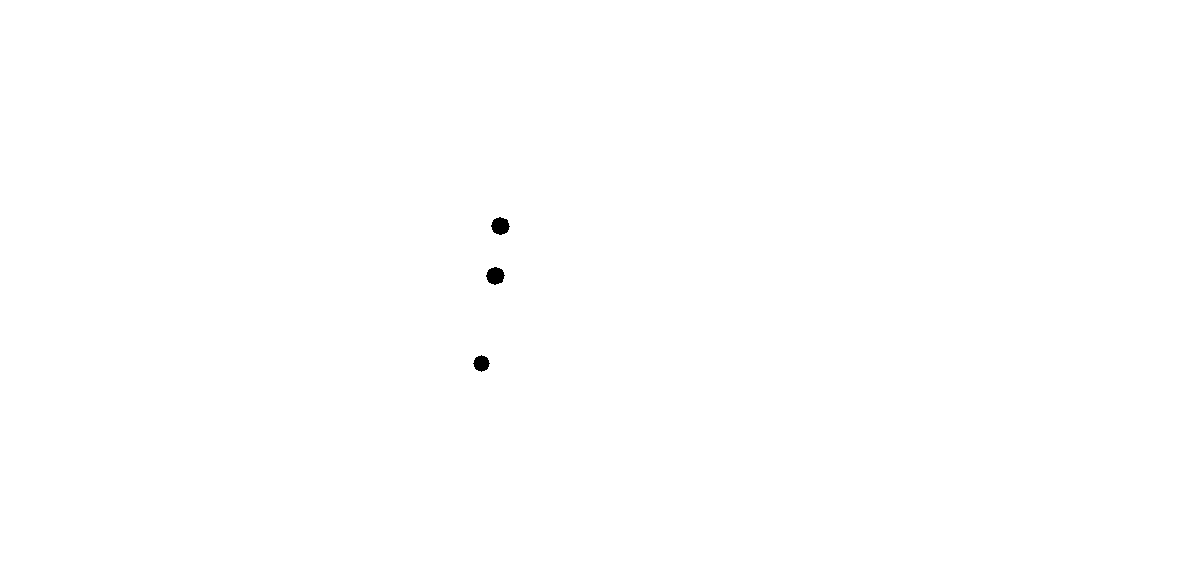

In [13]:
# Highlight segmented regions for easier bug fixing

seg2 = segmented.copy()
# "255*(not method) - seg2" needed because of weird threshold behaviour
# when method is BINARY (0) flips seg2, when method is BINARY_INV (1) negation keeps seg2 values because it's an unsigned int
cnts,_ = cv2.findContours(255*(not method)-seg2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
seg2 = cv2.drawContours(seg2, cnts, -1, 255*method, 15)
Image.fromarray(seg2)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

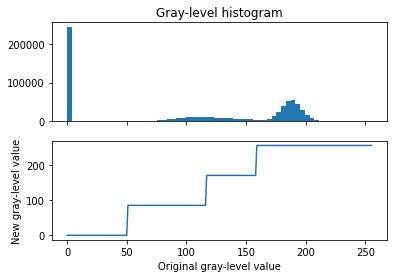

In [15]:
_, ax = plt.subplots(2, sharex=True)

ax[0].hist(le.flatten(), 64)
ax[0].set_title("Gray-level histogram")
ax[1].plot(classified)
ax[1].set(ylabel = "New gray-level value", xlabel="Original gray-level value")
plt.show()